In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchsummary
import torch.optim as optim
import os
import openpyxl
from torch.utils.data import TensorDataset, DataLoader,random_split
import tensorflow as tf

df = pd.read_excel("Data for headed bars_for DataFrame_220725.xlsx", skiprows = 17, engine = 'openpyxl', sheet_name= 'headed (2)' )
df = pd.DataFrame(df, columns = ["No.", "Author", "Year", "Test type", "Remark", "Specimen", "fy", "Ld", "fcm", "db", "b", "cos,avg",
                                 "cth", "ch", "Nh", "Bottom cover", "Ah/Ab", "Fsu at La, test", "dtr", "Ntr", "st"]) # st 제거시

df = df[df["Test type"] == "Joint type"]
y= df["Fsu at La, test"] 

pd.set_option('display.max_rows',None)

y2=y[~y.isnull()]
X = df[["Test type", "fy", "Ld", "fcm", "db", "b", "cos,avg", "cth", "ch", "Nh", "Bottom cover", "Ah/Ab", "st"]] 

X = pd.get_dummies(data = X, columns = ["Test type"], prefix = "Test_type")
X = X[~y.isnull()]

pd.options.display.max_rows = None
X.dropna(inplace = True)

y2 = y2[X.index]
y2 = y2.loc[(y2 != 0)] # series
X = X.loc[y2.index] # DataFrame

* train, test 분류

In [8]:
#test, train+valid 분류
from sklearn.model_selection import train_test_split
tf.random.set_seed(142)
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.20, random_state=142)
#print(X_test.shape, y_test.shape)

* 분류한 데이터 스케일링 후 텐서로 변환

In [16]:
# 분류한 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler
scX = MinMaxScaler() #형태는 넘파이
x_scaled = scX.fit_transform(X_train)   
x_test_scaled = scX.transform(X_test)

scY = MinMaxScaler()
y_scaled = scY.fit_transform(y_train.values.reshape(-1,1)) 
y_test_scaled = scY.transform(y_test.values.reshape(-1,1))

#스케일링->텐서로
x_test_tensor = torch.FloatTensor(x_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)
x_tensor = torch.FloatTensor(x_scaled)
y_tensor = torch.FloatTensor(y_scaled)

* 파이토치 이용한 모델 구현

In [19]:
#데이터 모델 클래스로 구현
class  MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super( MultivariateLinearRegressionModel, self).__init__()
        self.layer = nn.Linear(13, 1)

    def forward(self, x):
        return self.layer(x)
    
#커스텀 데이터 셋
class CustomDataset(TensorDataset): 
    def __init__(self):
        self.x = x_tensor
        self.y = y_tensor
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.FloatTensor(self.y[idx]) 
        return x, y
    
    def __len__(self): 
        return len(self.x)

#데이터 셋에서 train, validation 나누기 
dataset = CustomDataset()
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = dataset_size - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")

# 데이터 로더
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

Training Data Size : 172
Validation Data Size : 44


In [42]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultivariateLinearRegressionModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)
nb_epochs = 10000

for epoch in range(nb_epochs+1):
    running_loss = 0       
    running_accuracy = 0 
    for _,data in enumerate(train_dataloader):
        x,y =data
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)
        cost =criterion(prediction, y)
            
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        running_loss += cost.item()
        running_accuracy += torch.sum(prediction == y.data).detach().cpu().numpy()/x.size(0)
        
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for _,data in enumerate(validation_dataloader):
            x,y = data
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            cost = criterion(prediction, y)
            
            val_loss += cost.item()
            val_accuracy += torch.sum(prediction == y.data).detach().cpu().numpy()/x.size(0) #?

    # calculate mean for each batch
    train_losses.append(running_loss / len(train_dataloader))
    val_losses.append(val_loss / len(validation_dataloader))
    train_acc.append(running_accuracy / len(train_dataloader))
    val_acc.append(val_accuracy / len(validation_dataloader))
    
    if epoch % 1000 == 0:
        print("Epoch:{:4d}/{}".format(epoch, nb_epochs),
              "Train Loss: {:.6f}".format(running_loss / len(train_dataloader)),
              "Val Loss: {:.6f}".format(val_loss / len(validation_dataloader)))
              

history = {'train_loss': train_losses, 'val_loss': val_losses,
            'train_acc': train_acc, 'val_acc': val_acc}


Epoch:   0/10000 Train Loss: 0.175695 Val Loss: 0.045527
Epoch:1000/10000 Train Loss: 0.013406 Val Loss: 0.011851
Epoch:2000/10000 Train Loss: 0.012417 Val Loss: 0.012432
Epoch:3000/10000 Train Loss: 0.012616 Val Loss: 0.012617
Epoch:4000/10000 Train Loss: 0.012801 Val Loss: 0.011588
Epoch:5000/10000 Train Loss: 0.012815 Val Loss: 0.012941
Epoch:6000/10000 Train Loss: 0.014175 Val Loss: 0.014690
Epoch:7000/10000 Train Loss: 0.012272 Val Loss: 0.013018
Epoch:8000/10000 Train Loss: 0.013255 Val Loss: 0.012035
Epoch:9000/10000 Train Loss: 0.012299 Val Loss: 0.011859
Epoch:10000/10000 Train Loss: 0.012866 Val Loss: 0.013187


(<matplotlib.legend.Legend at 0x1bec47b2470>, None)

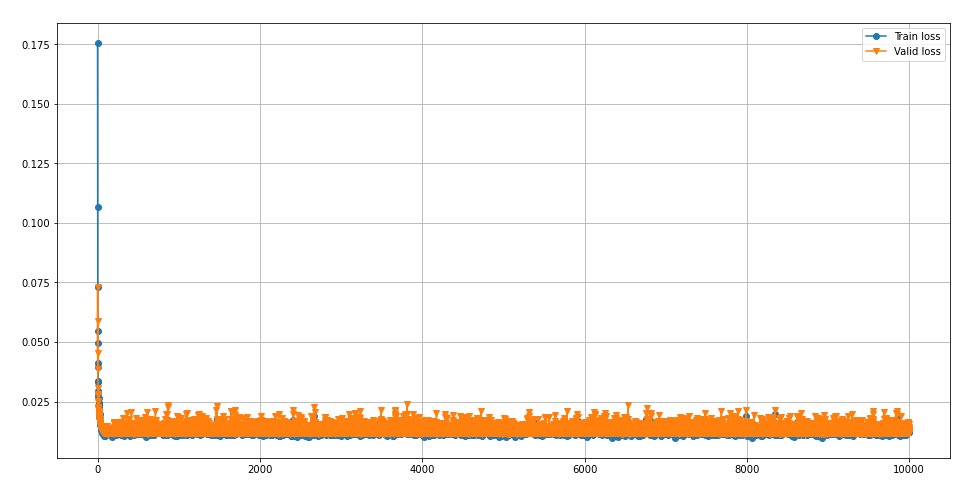

In [43]:
plt.figure(figsize = (16,8))
plt.plot(history['train_loss'], marker = 'o',label = "Train loss")
plt.plot(history['val_loss'], marker = 'v',label = "Valid loss")
plt.title(f'Loss', color='white', fontweight = 'bold');
plt.ylabel('Loss', color='white', fontweight = 'bold');
plt.xlabel('epoch', color='white', fontweight = 'bold')

plt.legend(), plt.grid()

* inputtype: 스케일된 텐서 --Model--> outputtype :스케일된텐서 
* X_test, y_test 는 DataFrame

In [44]:
y_p = model(x_test_tensor)
y_p[:10], y_test_scaled[:10]

(tensor([[0.0304],
         [0.4269],
         [0.4993],
         [0.4294],
         [0.5044],
         [0.3516],
         [0.6022],
         [0.4686],
         [0.6011],
         [0.3842]], grad_fn=<SliceBackward>),
 array([[0.00630971],
        [0.61743428],
        [0.41448432],
        [0.3316623 ],
        [0.50594864],
        [0.37568401],
        [0.65718885],
        [0.52827458],
        [0.81275021],
        [0.24812009]]))

In [45]:
y_test_unscaled = scY.inverse_transform(y_test_scaled)  
print(len(y_test_unscaled),y_test_unscaled, type(y_test_unscaled))

y_p_unscaled = scY.inverse_transform(y_p.detach().numpy())
print(len(y_p_unscaled),y_p_unscaled)

54 [[ 118.78727634]
 [ 704.        ]
 [ 509.65517241]
 [ 430.34482759]
 [ 597.24137931]
 [ 472.5       ]
 [ 742.06896552]
 [ 618.62068966]
 [ 891.03448276]
 [ 350.34482759]
 [ 540.        ]
 [ 661.37931034]
 [ 759.31034483]
 [ 189.65517241]
 [ 337.77148436]
 [ 367.        ]
 [ 346.71249424]
 [ 416.55172414]
 [ 550.        ]
 [ 892.4137931 ]
 [ 967.5862069 ]
 [ 951.72413793]
 [ 707.        ]
 [ 354.48275862]
 [ 657.93103448]
 [ 726.89655172]
 [ 907.5862069 ]
 [ 382.47653376]
 [ 312.5       ]
 [ 698.62068966]
 [ 354.66005857]
 [ 291.72413793]
 [ 417.        ]
 [ 275.86206897]
 [ 413.27334556]
 [ 626.89655172]
 [ 777.93103448]
 [ 623.44827586]
 [ 269.22374194]
 [ 544.82758621]
 [ 686.89655172]
 [ 534.48275862]
 [ 391.03448276]
 [ 687.5862069 ]
 [ 349.65517241]
 [ 446.89655172]
 [ 586.        ]
 [ 947.5862069 ]
 [1040.68965517]
 [ 320.68965517]
 [ 760.68965517]
 [ 843.44827586]
 [ 388.27586207]
 [ 538.7723909 ]] <class 'numpy.ndarray'>
54 [[141.90324]
 [521.5906 ]
 [590.8514 ]
 [523.94183]

C:\Users\lihwa\anaconda3\envs\trial1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


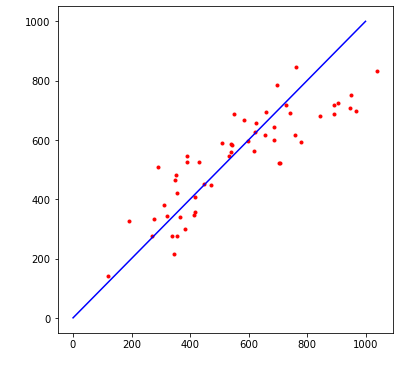

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y_test_unscaled, y_p_unscaled, 'r.')
ax.set_xlabel("Tested tensile stress, ft_test (MPa)", fontsize = 14,color = 'white')
ax.set_ylabel("Predicted tensile stress, ft_pred (MPa)", fontsize = 14, color = 'white')
x = np.linspace(0, 1000, 100)
y = x
ax.plot(x, y, 'b')
fig.show()


In [47]:
x_test_unscaled = scX.inverse_transform(x_test_scaled)  
print(x_test_unscaled)

[[450.6        217.          24.6         35.8        220.
   92.1        205.           0.           1.         369.
    5.         217.           1.        ]
 [649.         127.2        129.9         31.8        396.
   31.8         43.8        268.8          2.          84.8
    5.         127.2          1.        ]
 [799.31034483 233.426       46.27586207  25.4        439.42
   66.04        82.55       256.54         2.         260.35
    5.5        233.426        1.        ]
 [889.65517241 304.8         83.03448276  25.4        378.46
   62.23        76.2         50.8          4.         260.35
    5.1        304.8          1.        ]
 [799.31034483 203.2         40.68965517  25.4        439.42
   67.31        86.36       254.           2.         260.35
    5.5         76.2          1.        ]
 [583.         573.          51.4         57.3        584.46
   57.3         56.         355.26         2.         289.
    5.         275.           1.        ]
 [799.31034483 358.902   

모델 평가

In [48]:
#맞는지 모르겠습니다
test_loss = 0
test_accuracy = 0
model.eval()
with torch.no_grad():
    for i in range(len(y_test_unscaled)):
        pred = model(x_test_tensor)
        cost = criterion(pred, y_test_tensor)
        test_loss += cost.item()
        test_accuracy += torch.sum(pred == y_test_tensor).detach().cpu().numpy()/x_test_tensor.size(0)
        
    print('test_loss:',test_loss)
    print(f'test_acc:{test_accuracy:.3f}')# ?


test_loss: 0.8111852500587702
test_acc:0.000


In [49]:
division = y_p_unscaled / y_test_unscaled
cov = np.std(division) / np.mean(division)
print(cov)

0.23219517270524884


In [50]:
# torchmetrics 사용한 평가,,
import torchmetrics
import math
test_pred = torch.FloatTensor(y_p_unscaled).int()
test_label = torch.FloatTensor(y_test_unscaled).int()
acc = torchmetrics.functional.accuracy(test_pred, test_label)

for i in range(len(test_pred)):
    print(test_pred[i],'/', test_label[i])
acc

tensor([141], dtype=torch.int32) / tensor([118], dtype=torch.int32)
tensor([521], dtype=torch.int32) / tensor([704], dtype=torch.int32)
tensor([590], dtype=torch.int32) / tensor([509], dtype=torch.int32)
tensor([523], dtype=torch.int32) / tensor([430], dtype=torch.int32)
tensor([595], dtype=torch.int32) / tensor([597], dtype=torch.int32)
tensor([449], dtype=torch.int32) / tensor([472], dtype=torch.int32)
tensor([689], dtype=torch.int32) / tensor([742], dtype=torch.int32)
tensor([561], dtype=torch.int32) / tensor([618], dtype=torch.int32)
tensor([688], dtype=torch.int32) / tensor([891], dtype=torch.int32)
tensor([480], dtype=torch.int32) / tensor([350], dtype=torch.int32)
tensor([585], dtype=torch.int32) / tensor([540], dtype=torch.int32)
tensor([694], dtype=torch.int32) / tensor([661], dtype=torch.int32)
tensor([615], dtype=torch.int32) / tensor([759], dtype=torch.int32)
tensor([326], dtype=torch.int32) / tensor([189], dtype=torch.int32)
tensor([275], dtype=torch.int32) / tensor([337],

tensor(0.)